In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
base_path = '/Users/freezylex/Documents/course_work'
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Upload target

In [2]:
target_path = 'data/final_target.xlsx'
target = pd.read_excel(os.path.join(base_path, target_path), index_col = 'Date',
                       parse_dates=True)
target.drop(columns=['SU26217RMFS', 'SU26218RMFS'], inplace=True)
target.head(2)

,SU26214RMFS,SU26215RMFS,SU26216RMFS,SU26203RMFS,SU26204RMFS,SU26205RMFS,SU26206RMFS,SU26207RMFS,SU26208RMFS,SU26209RMFS,SU26210RMFS,SU26211RMFS,SU26212RMFS
Date,,,,,,,,,,,,,
2015-03-02,71.054960,15.591795,52.374278,-215.003930,-6.438351,69.280317,-77.673548,-82.483912,45.211617,46.084832,65.853786,32.091102,-103.946423
2015-03-03,-7.712548,-45.530358,-17.835183,-263.409824,-59.776986,-10.913728,-120.289471,-113.189118,-22.483303,-26.540902,-9.923194,-35.261262,-130.308823


## Upload metrics

In [7]:
metric_path = os.path.join(base_path, 'data/metrics_final')

rvi = pd.read_csv(os.path.join(metric_path, 'rvi.csv'), index_col = 'Date', parse_dates = True)
cds = pd.read_csv(os.path.join(metric_path, 'cds.csv'), index_col = 'Date', parse_dates = True)
usdrub = pd.read_csv(os.path.join(metric_path, 'usdrub.csv'), index_col = 'Date', parse_dates = True)

rvi = rvi.rolling(window=5).mean().loc['2015-06-01':]
cds = cds.rolling(window=5).mean().loc['2015-06-01':]
usdrub = usdrub.rolling(window=5).mean().loc['2015-06-01':]


## Join 

In [8]:
available_indexes = list((set(rvi.index) & set(cds.index) & \
                          set(usdrub.index) & set(target.index)))
available_indexes = np.sort(np.array(available_indexes))

In [9]:
target = target.loc[available_indexes]

rvi = rvi.loc[available_indexes]
cds = cds.loc[available_indexes]
usdrub = usdrub.loc[available_indexes]

## Create dataset

In [11]:
id_ = np.arange(1, len(target.columns) + 1)
id_ = np.tile(id_, cds.shape[0])

complete_data = pd.DataFrame(columns = ['id', 'time', 'bond', 'RVI', 'CDS','USDRUB','target'])
complete_data['id'] = id_
complete_data['time'] = np.repeat(target.index, repeats=13) #number of bonds
complete_data

,id,time,bond,RVI,CDS,USDRUB,target
0,1,2015-06-02,NaN,NaN,NaN,NaN,NaN
1,2,2015-06-02,NaN,NaN,NaN,NaN,NaN
2,3,2015-06-02,NaN,NaN,NaN,NaN,NaN
3,4,2015-06-02,NaN,NaN,NaN,NaN,NaN
4,5,2015-06-02,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
1802,9,2016-02-19,NaN,NaN,NaN,NaN,NaN
1803,10,2016-02-19,NaN,NaN,NaN,NaN,NaN
1804,11,2016-02-19,NaN,NaN,NaN,NaN,NaN
1805,12,2016-02-19,NaN,NaN,NaN,NaN,NaN


In [12]:
transfer = {'SU26214RMFS':1, 
            'SU26215RMFS':2, 
            'SU26216RMFS':3, 
            'SU26203RMFS':4,
            'SU26204RMFS':5, 
            'SU26205RMFS':6, 
            'SU26206RMFS':7, 
            'SU26207RMFS':8,
            'SU26208RMFS':9, 
            'SU26209RMFS':10, 
            'SU26210RMFS':11, 
            'SU26211RMFS':12,
            'SU26212RMFS':13}

def make_feature(df, feature_name):
    global complete_data
    for column in df.columns:
        bond_data = df[column]
        try: #Костыль, так как в текущем датасете нет одного бонда
            number = transfer[column]
            for date in bond_data.index:
                complete_data.loc[(complete_data['id'] ==number)&(complete_data['time'] == date), feature_name] = bond_data.loc[date]
        except:
            pass
            
list_with_dfs = [('target', target)]

for feature, dataframe in tqdm(list_with_dfs):
    make_feature(dataframe, feature)

100%|██████████| 1/1 [00:01<00:00,  1.40s/it]


In [14]:
complete_data['bond'] = np.tile(target.columns.values, reps=target.shape[0])

complete_data['RVI'] = np.repeat(rvi['RVI'].values, repeats=len(target.columns))
complete_data['RVI_struct_coef'] = np.repeat(rvi['struct_coef'].values, repeats=len(target.columns))
complete_data['struct_change_Jan'] = np.repeat(rvi['dummy_struct_change'].values, repeats=len(target.columns))

complete_data['CDS_dummy'] = np.repeat(cds['CDS_dummy_struct'].values, repeats=len(target.columns))
complete_data['CDS'] = np.repeat(cds['CDS1Y'].values, repeats=len(target.columns))
complete_data['CDS_new_slope'] = np.repeat(cds['CDS_struct_coef'].values, repeats=len(target.columns))

complete_data['USDRUB'] = np.repeat(usdrub['USDRUB_CBR'].values, repeats=len(target.columns))
complete_data['oil_shock_1st_USDRUB_dummy'] = np.repeat(usdrub['dummy_1_oil_shock'].values, repeats=len(target.columns))
complete_data['oil_shock_1st_USDRUB_coef'] = np.repeat(usdrub['USDcoef_oil_shock_1'].values, repeats=len(target.columns))


In [15]:
complete_data.head(2)

,id,time,bond,RVI,CDS,USDRUB,target,RVI_struct_coef,struct_change_Jan,CDS_dummy,CDS_new_slope,oil_shock_1st_USDRUB_dummy,oil_shock_1st_USDRUB_coef
0,1,2015-06-02,SU26214RMFS,36.924,224.442,51.88474,-79.848597,0.0,0.0,0.0,0.0,1.0,51.88474
1,2,2015-06-02,SU26215RMFS,36.924,224.442,51.88474,-74.947765,0.0,0.0,0.0,0.0,1.0,51.88474


In [16]:
train_sample = complete_data[complete_data['time'] < '2016-02-01']
test_sample = complete_data[complete_data['time'] > '2016-02-01']

In [17]:
train_sample.to_excel(os.path.join(base_path, 'data/rolling_window_train.xlsx'))
test_sample.to_excel(os.path.join(base_path, 'data/rolling_window_test.xlsx'))

## Predict

In [18]:
from linearmodels import RandomEffects
import statsmodels.api as sm

In [19]:
train_sample = train_sample.set_index(['id', 'time'])

In [20]:
exog_vars = ['CDS', 'CDS_new_slope', 'CDS_dummy', 'RVI', 'RVI_struct_coef', 'struct_change_Jan',
             'USDRUB']
exog = sm.add_constant(train_sample[exog_vars])
mod = RandomEffects(train_sample.target, exog)
re_res = mod.fit(cov_type='heteroskedastic')

In [21]:
re_res

Dep. Variable:,target,R-squared:,0.4664
Estimator:,RandomEffects,R-squared (Between):,0.0000
No. Observations:,1651,R-squared (Within):,0.4671
Date:,"Mon, Apr 04 2022",R-squared (Overall):,0.2096
Time:,21:58:44,Log-likelihood,-7618.9
Cov. Estimator:,Robust,,
,,F-statistic:,205.14
Entities:,13,P-value,0.0000
Avg Obs:,127.00,Distribution:,"F(7,1643)"
Min Obs:,127.00,,
Max Obs:,127.00,F-statistic (robust):,223.69


## Test the model

In [22]:
test_sample_ = test_sample.set_index(['id', 'time'])
test_sample_ = sm.add_constant(test_sample_[exog_vars])

In [23]:
test_sample_['const'] = 1
test_sample_ = test_sample_[['const'] + exog_vars]

In [24]:
preds = re_res.predict(test_sample_)

In [25]:
test = test_sample.reset_index().merge(preds.reset_index(), on=['id', 'time'])

In [26]:
test = test[['id', 'time', 'target', 'predictions']]
test

,id,time,target,predictions
0,1,2016-02-02,-110.035299,-85.742225
1,2,2016-02-02,-97.857671,-85.742225
2,3,2016-02-02,-124.628027,-85.742225
3,4,2016-02-02,-273.127797,-85.742225
4,5,2016-02-02,-155.680297,-85.742225
...,...,...,...,...
151,9,2016-02-19,-135.571238,-86.175613
152,10,2016-02-19,-108.267943,-86.175613
153,11,2016-02-19,-122.901634,-86.175613
154,12,2016-02-19,-107.490498,-86.175613


In [27]:
inverse_transfer = {}
for key, val in transfer.items():
    inverse_transfer[val] = key

In [28]:
test['target'] = test['target'].astype('float')

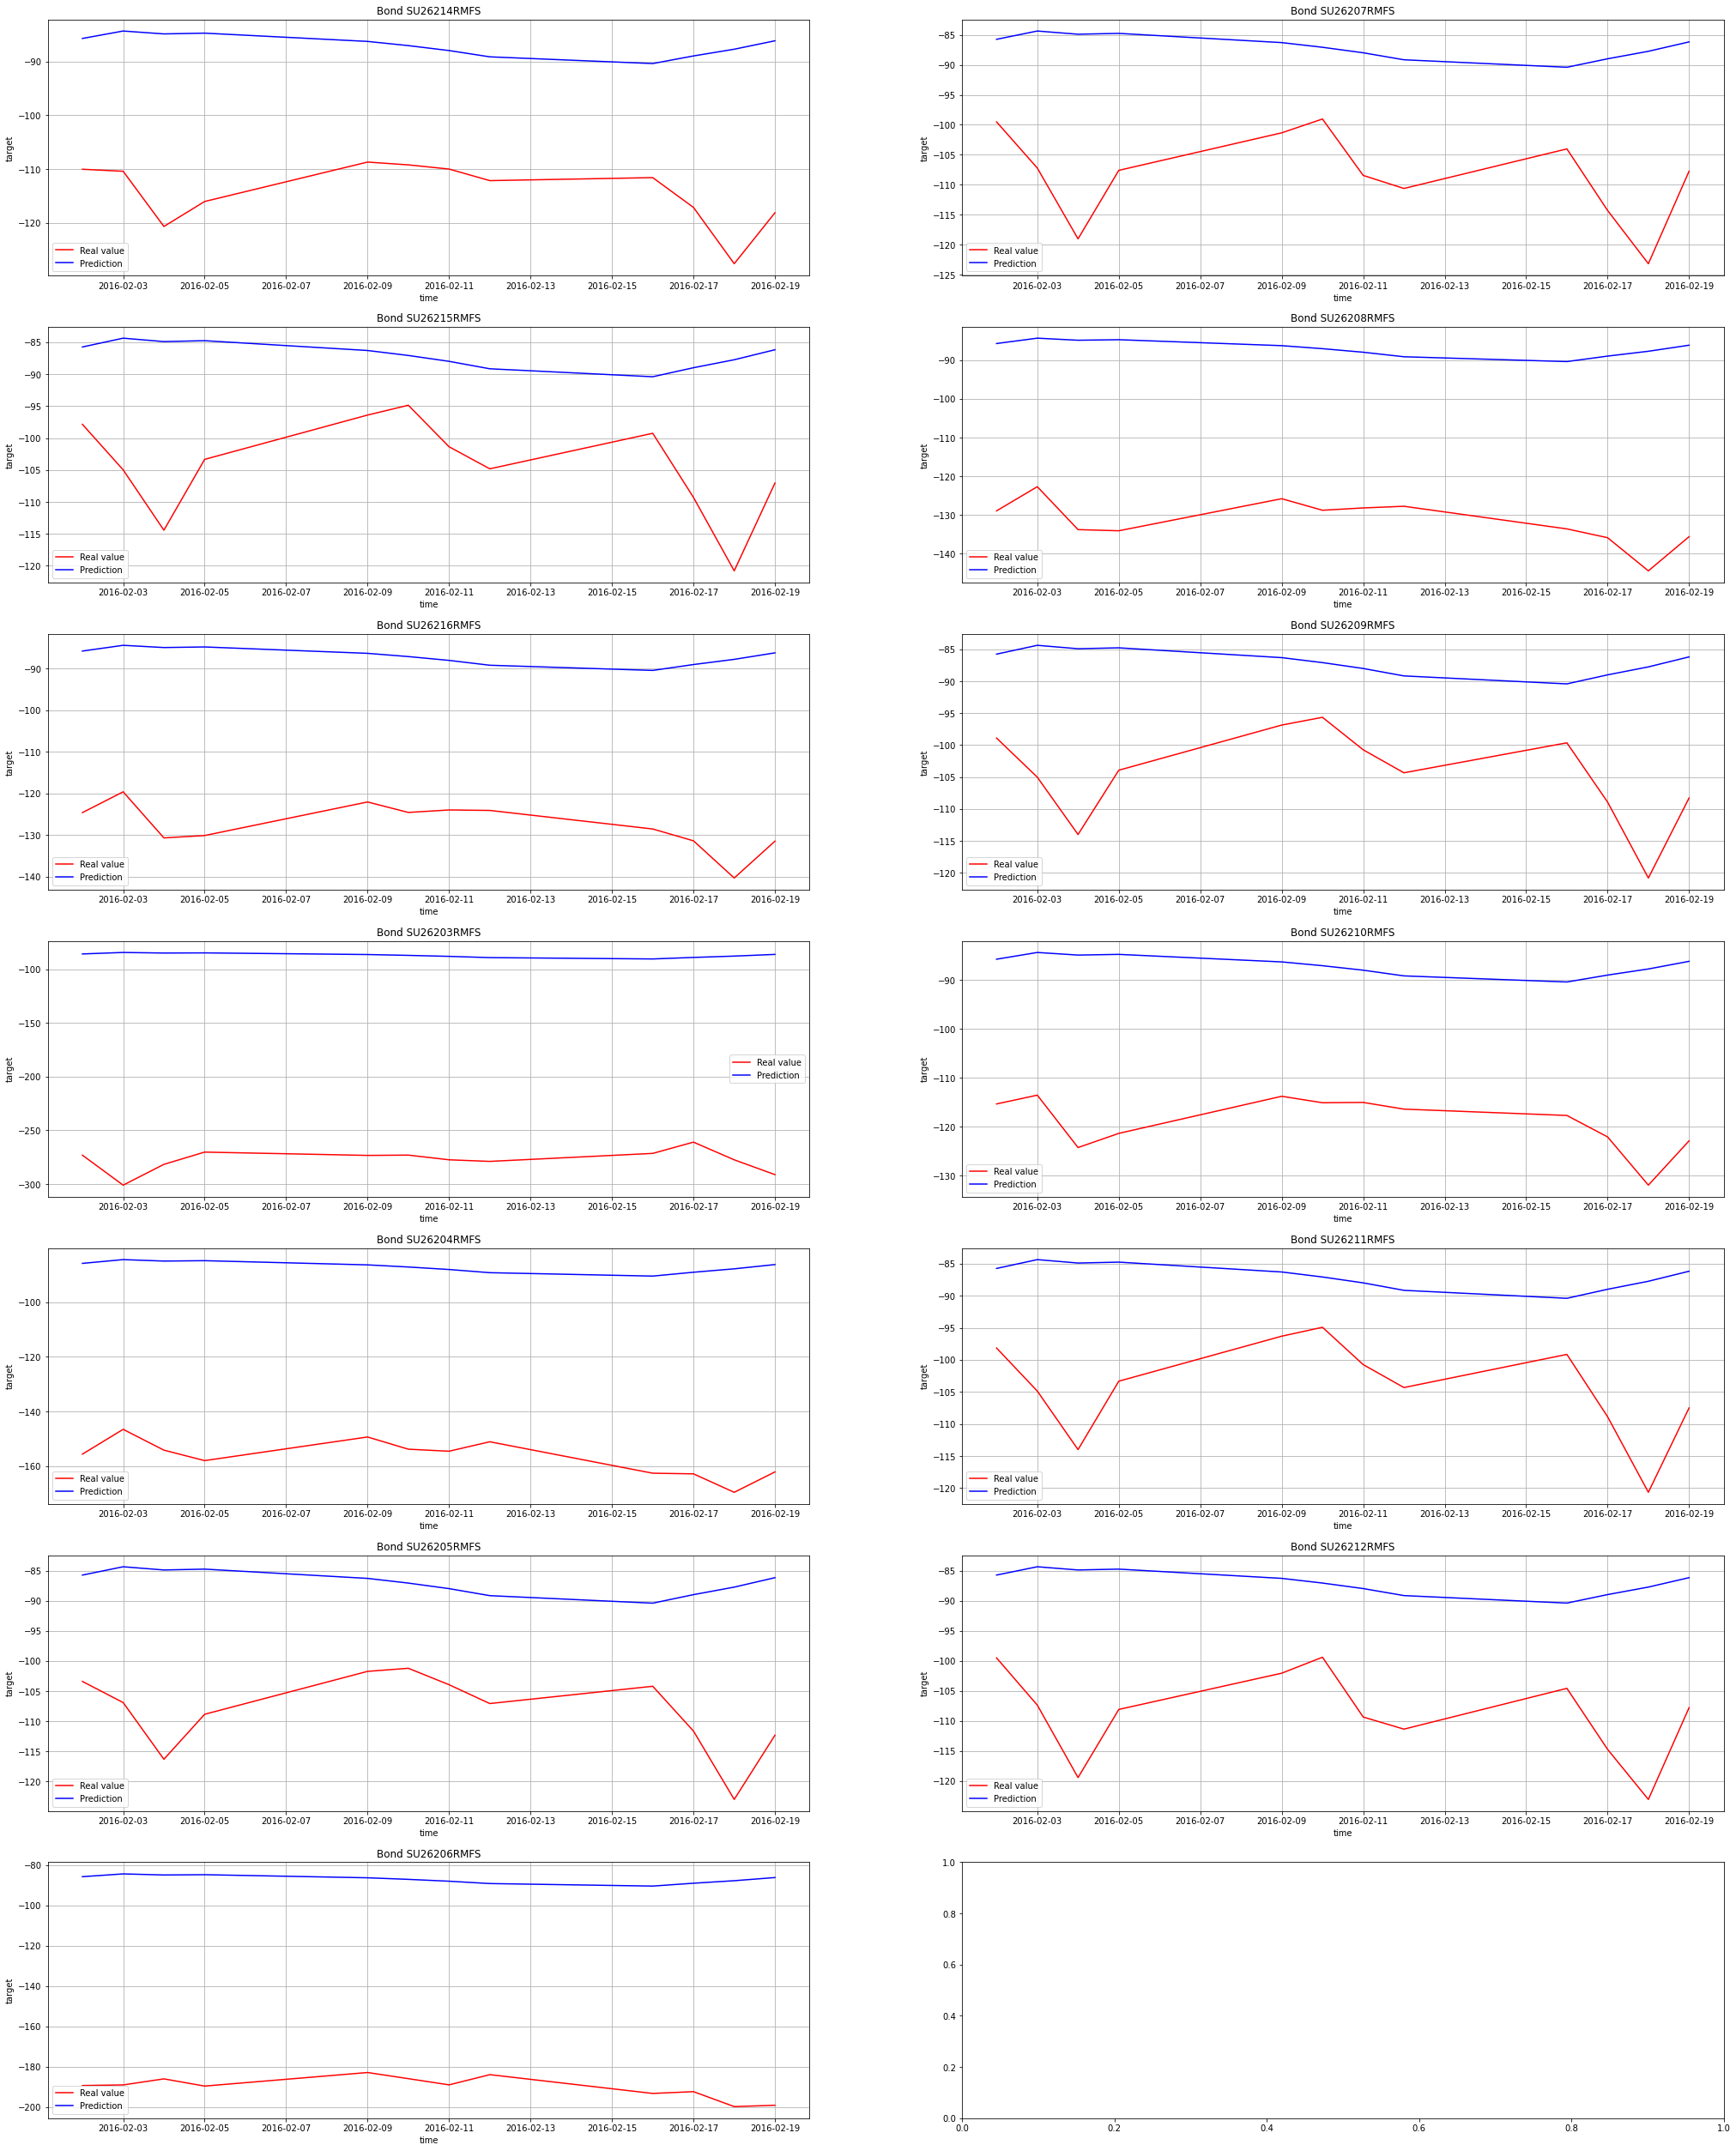

In [29]:
fig, ax = plt.subplots(7, 2, figsize=(35, 45))
i = 0
for ind, obj in test.groupby('id'):
    if i >= 7:
        sns.lineplot(x = obj['time'], y = obj['target'], color='r', label='Real value', ax = ax[i-7, 1])
        sns.lineplot(x = obj['time'], y = obj['predictions'], color='b', label='Prediction', ax = ax[i-7, 1])
        ax[i-7, 1].grid()
        ax[i-7, 1].set_title(f'Bond {inverse_transfer[ind]}')
    else:
        sns.lineplot(x = obj['time'], y = obj['target'], color='r', label='Real value', ax = ax[i, 0])
        sns.lineplot(x = obj['time'], y = obj['predictions'], color='b', label='Prediction', ax = ax[i, 0])
        #plt.title(f'Bond {inverse_transfer[ind]}')
        ax[i, 0].grid()
        ax[i, 0].set_title(f'Bond {inverse_transfer[ind]}')
    i += 1

In [30]:
test['error'] = np.abs(test['target'] - test['predictions'])
test['error_2'] = test['error'] ** 2

In [31]:
results = pd.concat([test.groupby('id').mean()[['error']], np.sqrt(test.groupby('id').mean()[['error_2']])], axis=1)
results.columns = ['MAE', 'RMSE']
results

,MAE,RMSE
id,,
1,27.336891,27.957602
2,17.578031,19.144489
3,40.678601,41.029200
4,190.532394,190.846406
5,69.789147,70.029796
6,21.407321,22.408268
7,103.153894,103.283674
8,21.527303,22.707531
9,44.637340,44.960610


## Get same metrics from train sample

In [32]:
preds_train = re_res.fitted_values

In [33]:
ts_with_pr = train_sample.reset_index().merge(preds_train.reset_index(), on=['id', 'time'])

In [34]:
ts_with_pr = ts_with_pr[['id', 'time', 'target', 'fitted_values']]
ts_with_pr[['id', 'target', 'fitted_values']] = ts_with_pr[['id', 'target', 'fitted_values']].astype('float')
ts_with_pr['error'] = np.abs(ts_with_pr['target'] - ts_with_pr['fitted_values'])
ts_with_pr['error_2'] = ts_with_pr['error'] ** 2

results_train = pd.concat([ts_with_pr.groupby('id').mean()[['error']], np.sqrt(ts_with_pr.groupby('id').mean()[['error_2']])], axis=1)
results_train.columns = ['MAE', 'RMSE']
results_train

,MAE,RMSE
id,,
1.0,23.188208,28.035616
2.0,25.298418,31.431204
3.0,19.366274,23.207744
4.0,116.141645,122.988696
5.0,19.035164,24.357845
6.0,24.734015,30.424130
7.0,38.031641,45.926083
8.0,21.578067,26.303232
9.0,18.581543,22.208318
